In [55]:
import os
import cv2
import json
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [56]:
# Путь к папке с JSON файлами
json_folder = r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\train\ann'

# Путь к выходному CSV файлу
csv_file = r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\train.csv'

# Создаем CSV файл и записываем заголовки
with open(csv_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['FILENAME', 'IDENTITY']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=',')  # Добавлен delimiter=','
    writer.writeheader()

    # Перебираем JSON файлы в папке
    for filename in os.listdir(json_folder):
        if filename.endswith('.json'):
            with open(os.path.join(json_folder, filename), 'r', encoding='utf-8') as jsonfile:
                data = json.load(jsonfile)
                # Записываем данные в CSV файл
                writer.writerow({
                    'FILENAME': data['name'] + '.png',
                    'IDENTITY': data['description']
                })

In [57]:
# Путь к папке с JSON файлами
json_folder = r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\val\ann'

# Путь к выходному CSV файлу
csv_file = r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\val.csv'

# Создаем CSV файл и записываем заголовки
with open(csv_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['FILENAME', 'IDENTITY']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=',')  # Добавлен delimiter=','
    writer.writeheader()

    # Перебираем JSON файлы в папке
    for filename in os.listdir(json_folder):
        if filename.endswith('.json'):
            with open(os.path.join(json_folder, filename), 'r', encoding='utf-8') as jsonfile:
                data = json.load(jsonfile)
                # Записываем данные в CSV файл
                writer.writerow({
                    'FILENAME': data['name'] + '.png',
                    'IDENTITY': data['description']
                })

In [58]:
train = pd.read_csv(r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\train.csv')
valid = pd.read_csv(r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\val.csv')

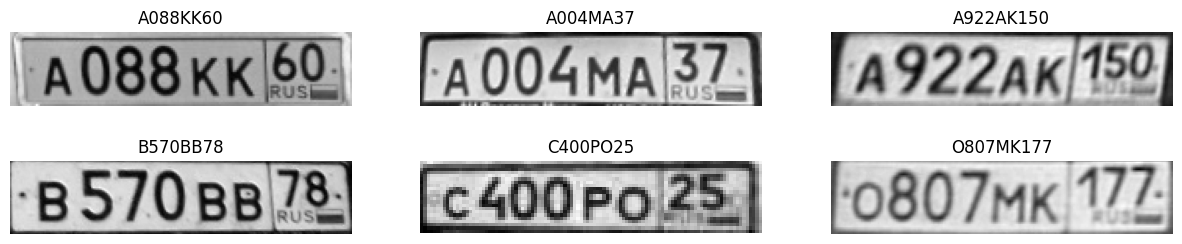

In [59]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'C:\\Users\\MSI_KATANA\\Desktop\\neuro\\autoriaNumberplateOcrRu-2021-09-01\\train\\img\\' + train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [60]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  0
Number of NaNs in validation set :  0


In [61]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [62]:
train_size = 49382
valid_size= 4893

In [63]:
train_x = []

for i in range(train_size):
    img_dir = 'C:\\Users\\MSI_KATANA\\Desktop\\neuro\\autoriaNumberplateOcrRu-2021-09-01\\train\\img\\'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [64]:
valid_x = []

for i in range(valid_size):
    img_dir = 'C:\\Users\\MSI_KATANA\\Desktop\\neuro\\autoriaNumberplateOcrRu-2021-09-01\\val\\img\\'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [65]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [131]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"
max_str_len = 9
num_of_characters = len(alphabets) + 1
num_of_timestamps = 64
batch_size = 128

def label_to_num(label):
    label_num = []
    for ch in label:
        
            label_num.append(alphabets.find(ch) if alphabets.find(ch)!=-1 else alphabets.find('-'))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [132]:
name = ''
print(name, '\n',label_to_num(name))

 
 []


In [133]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

In [134]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])

In [135]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  T874HH35 
train_y :  [19. 33. 32. 29.  7.  7. 28. 30. -1.] 
train_label_len :  [8.] 
train_input_len :  [62.]


In [136]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization_12 (Bat  (None, 256, 64, 32)      128       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                           

In [137]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [138]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [145]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=2, batch_size=128)

Epoch 1/2
176/386 [============>.................] - ETA: 7:17 - loss: 23.9589

In [140]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

153/153 [==============================] - 31s 199ms/step


In [144]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 0.00%
Correct words predicted      : 0.00%


In [84]:
# Путь к папке с JSON файлами
json_folder = r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\test\ann'

# Путь к выходному CSV файлу
csv_file = r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\test.csv'

# Создаем CSV файл и записываем заголовки
with open(csv_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['FILENAME', 'IDENTITY']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=',')  # Добавлен delimiter=','
    writer.writeheader()

    # Перебираем JSON файлы в папке
    for filename in os.listdir(json_folder):
        if filename.endswith('.json'):
            with open(os.path.join(json_folder, filename), 'r', encoding='utf-8') as jsonfile:
                data = json.load(jsonfile)
                # Записываем данные в CSV файл
                writer.writerow({
                    'FILENAME': data['name'] + '.png',
                    'IDENTITY': data['description']
                })

1/1 [==============================] - 0s 27ms/step


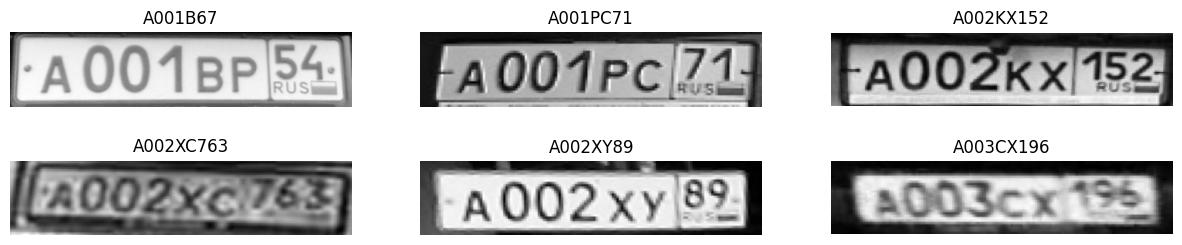

In [85]:
test = pd.read_csv(r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\test.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'C:\\Users\\MSI_KATANA\\Desktop\\neuro\\autoriaNumberplateOcrRu-2021-09-01\\test\\img\\'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

1/1 [==============================] - 0s 27ms/step


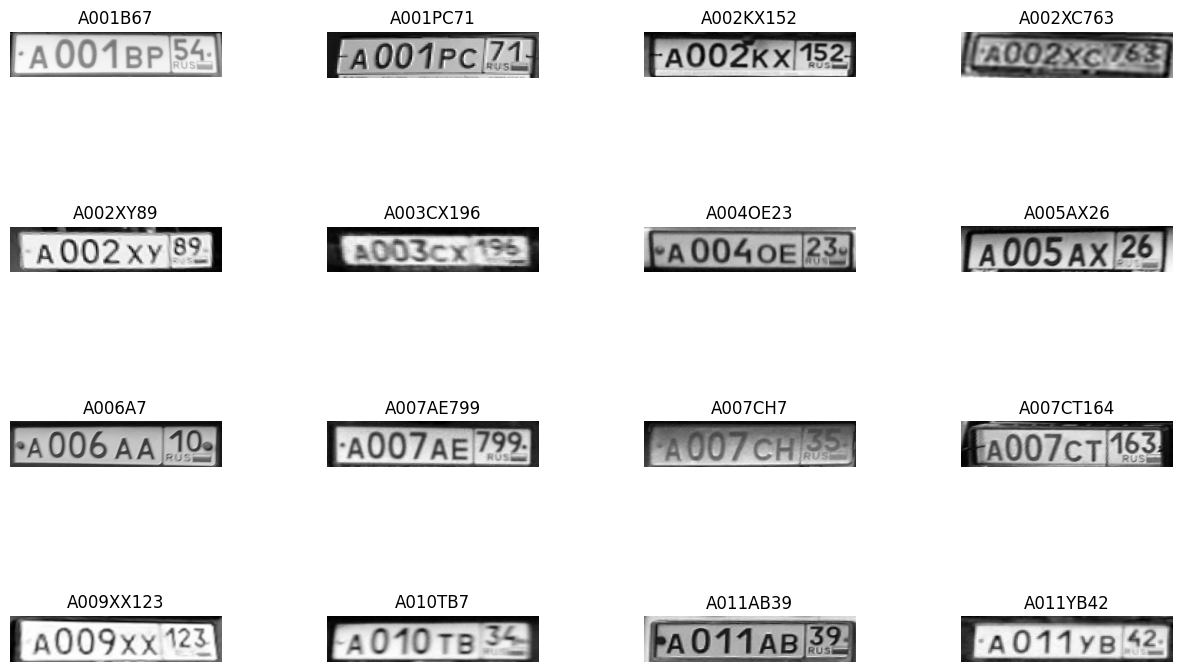

In [93]:
test = pd.read_csv(r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\test.csv')

plt.figure(figsize=(15, 10))

num_images = 16

rows = 4
cols = 4

for i in range(num_images):
    ax = plt.subplot(rows, cols, i+1)
    img_dir = 'C:\\Users\\MSI_KATANA\\Desktop\\neuro\\autoriaNumberplateOcrRu-2021-09-01\\test\\img\\'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.5, hspace=0.05)


In [94]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk

In [111]:
# Функция для обработки изображения и вывода результата
def process_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_copy = image.copy()  # Создание копии изображения
    image = preprocess(image)
    image = image / 255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1],
                                       greedy=True)[0][0])
    result = num_to_label(decoded[0])
    return image_copy, result

# Функция для выбора изображения
def select_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        image, result = process_image(file_path)
        # Отобразить изображение
        image = Image.fromarray(image)
        image.thumbnail((400, 400))
        photo = ImageTk.PhotoImage(image)
        image_label.config(image=photo)
        image_label.image = photo
        # Отобразить результат
        result_label.config(text=result)

In [113]:
# Создание основного окна
root = tk.Tk()
root.title("OCR Interface")
root.geometry("400x200")  # Установка размеров окна

# Цвета
root.configure(bg="#f0f0f0")  # Фоновый цвет
button_bg = "#4CAF50"  # Цвет кнопки
button_fg = "white"     # Цвет текста на кнопке

# Создание кнопки для выбора изображения
select_button = tk.Button(root, text="Выбрать изображение", command=select_image, bg=button_bg, fg=button_fg)
select_button.pack(pady=10)

# Метка для вывода результата
result_label = tk.Label(root, text="", font=("Helvetica", 16), bg="#f0f0f0")
result_label.pack(pady=10)

# Метка для отображения изображения
image_label = tk.Label(root)
image_label.pack(pady=10)

root.mainloop()

1/1 [==============================] - 0s 26ms/step
